# **Automated Resume Screening and Job Matching**

## **Objective**:
#### - Explore the datasets (Resumes and Job Descriptions).
#### - Preprocess the text data.
#### - Train and evaluate transformer-based models (BERT/GPT).
#### - Match resumes with job descriptions and rank candidates.

---

## 1. EDA (Exploratory Data Analysis)

### **Explanation** - This EDA focuses on loading the dataset, exploring the distribution of resume and job description lengths, identifying any missing values, and visualizing the most common words using word clouds. This step is crucial for understanding the dataset before moving to the model training phase.

### 1.1 Load and Explore Datasets

In [20]:
#Importing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import BertTokenizer, BertModel
import torch
from collections import Counter
from wordcloud import WordCloud
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE 
from sklearn.preprocessing import LabelEncoder
import pickle

In [21]:
# Load the datasets
resume_df = pd.read_csv('dataset/resume_dataset.csv')
job_desc_df = pd.read_csv('dataset/job_description_dataset.csv')

# Display the first few rows of each dataset to understand their structure
print("Resume Dataset:")
print(resume_df.head())

print("Job Description Dataset:")
print(job_desc_df.head())

Resume Dataset:
         ID                                         Resume_str  \
0  16852973           HR ADMINISTRATOR/MARKETING ASSOCIATE\...   
1  22323967           HR SPECIALIST, US HR OPERATIONS      ...   
2  33176873           HR DIRECTOR       Summary      Over 2...   
3  27018550           HR SPECIALIST       Summary    Dedica...   
4  17812897           HR MANAGER         Skill Highlights  ...   

                                         Resume_html Category  
0  <div class="fontsize fontface vmargins hmargin...       HR  
1  <div class="fontsize fontface vmargins hmargin...       HR  
2  <div class="fontsize fontface vmargins hmargin...       HR  
3  <div class="fontsize fontface vmargins hmargin...       HR  
4  <div class="fontsize fontface vmargins hmargin...       HR  
Job Description Dataset:
       domain                                    job_description
0  ACCOUNTANT  ACCOUNTANT\nSummary\nAccomplished and results-...
1  ACCOUNTANT  SENIOR ACCOUNTANT\nSummary\nSenio

In [22]:
# Basic statistics for resumes
resume_df['Resume_str'] = resume_df['Resume_str'].fillna('').astype(str)
resume_df['resume_length'] = resume_df['Resume_str'].apply(lambda x: len(x.split()))
print("Summary statistics for Resume lengths:")
print(resume_df['resume_length'].describe())

# Basic statistics for job descriptions
job_desc_df['job_description'] = job_desc_df['job_description'].fillna('').astype(str)
job_desc_df['job_description_length'] = job_desc_df['job_description'].apply(lambda x: len(x.split()))
print("Summary statistics for Job Description lengths:")
print(job_desc_df['job_description_length'].describe())

Summary statistics for Resume lengths:
count    2484.000000
mean      811.325684
std       371.006906
min         0.000000
25%       651.000000
50%       757.000000
75%       933.000000
max      5190.000000
Name: resume_length, dtype: float64
Summary statistics for Job Description lengths:
count    2484.000000
mean      812.407005
std       362.172659
min         0.000000
25%       652.000000
50%       760.000000
75%       934.250000
max      5190.000000
Name: job_description_length, dtype: float64


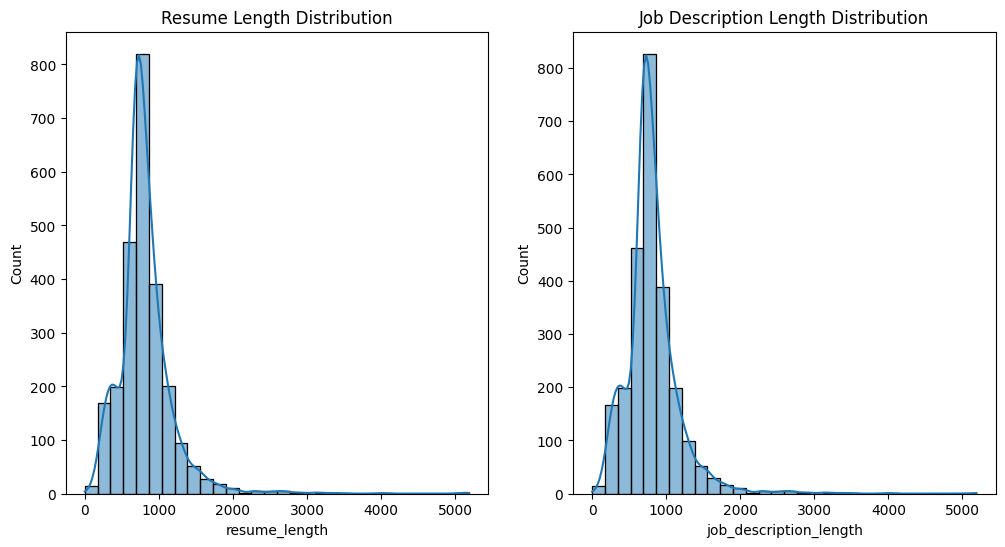

In [23]:
# Visualize the distribution of resume and job description lengths
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(resume_df['resume_length'], bins=30, kde=True)
plt.title('Resume Length Distribution')

plt.subplot(1, 2, 2)
sns.histplot(job_desc_df['job_description_length'], bins=30, kde=True)
plt.title('Job Description Length Distribution')

plt.show()

### 1.2 Analyze the Data

In [24]:
# Check for any missing values in each dataset
print("Missing values in Resume dataset:\n", resume_df.isnull().sum())
print("Missing values in Job Description dataset:\n", job_desc_df.isnull().sum())

Missing values in Resume dataset:
 ID               0
Resume_str       0
Resume_html      0
Category         0
resume_length    0
dtype: int64
Missing values in Job Description dataset:
 domain                    0
job_description           0
job_description_length    0
dtype: int64


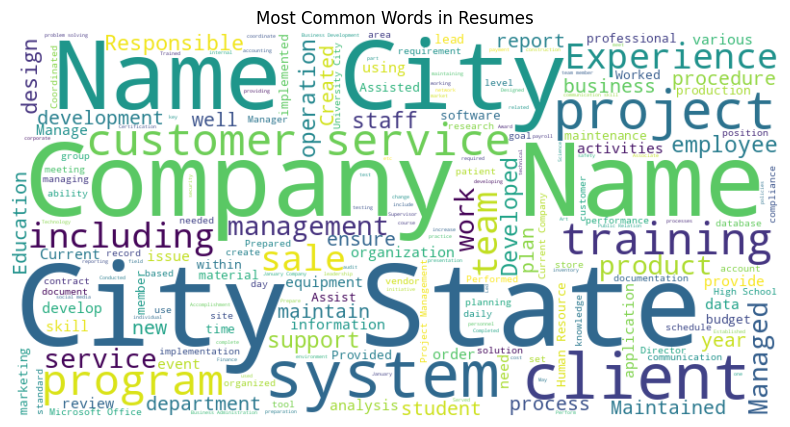

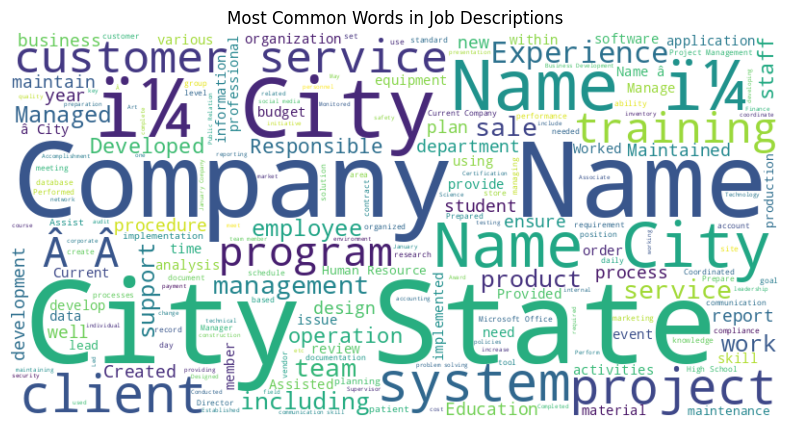

In [25]:
# Get the most common words in resumes
def plot_wordcloud(text_data, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(" ".join(text_data))
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

plot_wordcloud(resume_df['Resume_str'], "Most Common Words in Resumes")
plot_wordcloud(job_desc_df['job_description'], "Most Common Words in Job Descriptions")

In [26]:
# Check for the class distribution 
class_counts = job_desc_df['domain'].value_counts()

# Print the class distribution
print("Class Distribution:\n", class_counts)

# Calculate the percentage of each class
class_percentages = job_desc_df['domain'].value_counts(normalize=True) * 100
print("Class Percentages:\n", class_percentages)

Class Distribution:
 domain
INFORMATION-TECHNOLOGY    120
BUSINESS-DEVELOPMENT      120
ACCOUNTANT                118
ADVOCATE                  118
FINANCE                   118
ENGINEERING               118
CHEF                      118
AVIATION                  117
FITNESS                   117
SALES                     116
BANKING                   115
HEALTHCARE                115
CONSULTANT                115
CONSTRUCTION              112
PUBLIC-RELATIONS          111
HR                        110
DESIGNER                  107
ARTS                      103
TEACHER                   102
APPAREL                    97
DIGITAL-MEDIA              96
AGRICULTURE                63
AUTOMOBILE                 36
BPO                        22
Name: count, dtype: int64
Class Percentages:
 domain
INFORMATION-TECHNOLOGY    4.830918
BUSINESS-DEVELOPMENT      4.830918
ACCOUNTANT                4.750403
ADVOCATE                  4.750403
FINANCE                   4.750403
ENGINEERING             

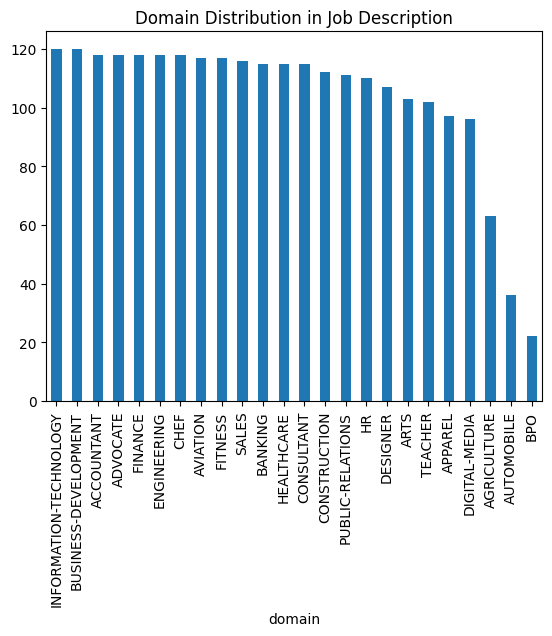

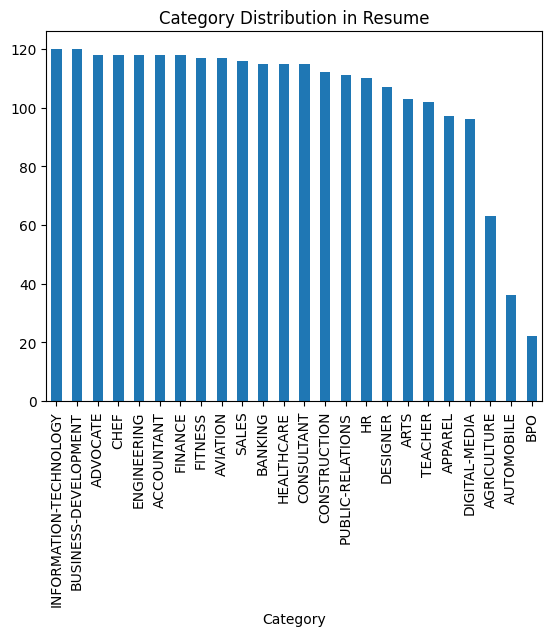

In [27]:
# Check for class imbalance if domain are present
if 'domain' in job_desc_df.columns:
    job_desc_df['domain'].value_counts().plot(kind='bar')
    plt.title('Domain Distribution in Job Description')
    plt.show()      

# Check for class imbalance if category are present
if 'Category' in resume_df.columns:
    resume_df['Category'].value_counts().plot(kind='bar')
    plt.title('Category Distribution in Resume')
    plt.show()      

## 2. Preprocessing the Data

### **Explanation** - This Preprocessing step includes tokenizing the text using BERT's tokenizer. Resumes and job descriptions are transformed into token IDs that can be input to a transformer model for feature extraction. Padding and truncation are applied to ensure that all sequences have the same length, making them suitable for batch processing.

### 2.1 Tokenization using BERT Tokenizer

In [28]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def tokenize_data(text_data):
    tokens = tokenizer(text_data, return_tensors='pt', truncation=True, padding=True)
    return tokens

# Example tokenization for a single resume and job description
sample_resume = resume_df['Resume_str'][0]
sample_job_desc = job_desc_df['job_description'][0]

print("Sample Resume Tokenization:")
print(tokenize_data(sample_resume))

print("\nSample Job Description Tokenization:")
print(tokenize_data(sample_job_desc))

Sample Resume Tokenization:
{'input_ids': tensor([[  101, 17850,  8911,  1013,  5821,  5482, 17850,  8911, 12654,  4056,
          8013,  2326,  3208,  2007,  2321,  1009,  2086,  1997,  3325,  1999,
         15961,  1998,  8013,  2326,  2968,  1012,  9768, 12508,  1998,  3003,
          1997,  8013,  1011,  4208,  2780,  1025, 29453,  2015,  2000, 16021,
         28345,  1037,  4207,  1010, 14727,  8426,  2000,  8013,  2326,  1012,
         11637,  4208,  2006,  8013,  9967,  2136,  2968,  5821,  7842,  2615,
         10736,  4736,  5813,  5461,  2731,  1998,  2458, 10571,  4800,  1011,
          4708,  2121,  7396,  4262,  8325, 17571,  5284, 11089, 12366,  2731,
         10618,  7378,  2011,  1045, 25619,  1999,  8013,  9721,  1998,  5821,
          2011,  6903, 15481,  4969,  2236,  3208,  2731, 10618,  8885, 10365,
          2005,  2892,  8241, 15961,  3001,  2107,  2004, 15481,  2006,  4160,
          1010, 12702,  2015,  3850,  7610,  2015,  1010, 26000, 12798,  3850,
         1

/DATA/sushant_2311ai09/miniconda3/envs/torch_MTP/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


### 2.2 Batch Tokenization for Model Training

In [29]:
# Tokenize all resumes and job descriptions in the dataset
resume_df['resume_tokens'] = resume_df['Resume_str'].apply(lambda x: tokenize_data(x)['input_ids'])
job_desc_df['job_description_tokens'] = job_desc_df['job_description'].apply(lambda x: tokenize_data(x)['input_ids'])

# Preprocessing for BERT requires padding and truncating sequences to a fixed length
MAX_LENGTH = 512
resume_df['resume_tokens'] = resume_df['resume_tokens'].apply(lambda x: x[:, :MAX_LENGTH])
job_desc_df['job_description_tokens'] = job_desc_df['job_description_tokens'].apply(lambda x: x[:, :MAX_LENGTH])

## 3. Model Training - Feature Extraction with BERT

### **Explanation** - The BERT model is used to extract deep contextual embeddings from resumes and job descriptions. These embeddings serve as the basis for measuring the similarity between candidates and job descriptions. The embeddings are saved for later use.

In [30]:
# Check if GPU is available
device = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')

# Initialize Pretrained BERT Model and move it to GPU if available
model = BertModel.from_pretrained('bert-base-uncased').to(device)

# Define a function to extract features on the GPU
def extract_features(tokens):
    tokens = tokens.to(device)  # Move input tokens to GPU
    with torch.no_grad():
        outputs = model(input_ids=tokens)
        return outputs.last_hidden_state.mean(dim=1).cpu()  # Pool the embeddings and move back to CPU

# Assuming you have tokenized resumes and job descriptions as tensors
resume_df['resume_features'] = resume_df['resume_tokens'].apply(lambda x: extract_features(x))
job_desc_df['job_description_features'] = job_desc_df['job_description_tokens'].apply(lambda x: extract_features(x))

# Convert features to numpy for easier similarity computations
resume_features = torch.stack(resume_df['resume_features'].values.tolist()).cpu().numpy()
job_desc_features = torch.stack(job_desc_df['job_description_features'].values.tolist()).cpu().numpy()

# Save extracted features for reuse
np.save('resume_features.npy', resume_features)
np.save('job_desc_features.npy', job_desc_features)

## 4. Evaluation and Candidate Ranking

### **Explanation** - Euclidean Distance is computed between resume and job description embeddings to rank candidates. The performance is evaluated using common metrics like precision, recall, and F1-score, assuming ground truth labels are available.

In [16]:
# Load the extracted resume and job description features
resume_features = np.load('resume_features.npy')  # shape: (num_resumes, feature_dim)
job_desc_features = np.load('job_desc_features.npy')  # shape: (num_job_descs, feature_dim)

# Handle class imbalance in `resume_df['Category']` (not on embeddings)
categories = resume_df['Category']

# Encode labels as SMOTE expects numerical values for y
label_encoder = LabelEncoder()
categories_encoded = label_encoder.fit_transform(categories)

# Use SMOTE to resample only the labels
smote = SMOTE()
resampled_indices, y_resampled = smote.fit_resample(np.arange(len(categories)).reshape(-1, 1), categories_encoded)

# Use the resampled indices to filter resume features and resume_df
resume_df_balanced = resume_df.iloc[resampled_indices.flatten()]
resume_features_resampled = resume_features[resampled_indices.flatten()]

# Convert resampled resume features and job description features to PyTorch tensors
resume_features_tensor = torch.tensor(resume_features_resampled).to(device)
job_desc_features_tensor = torch.tensor(job_desc_features).to(device)

# Compute Euclidean distance using PyTorch (on GPU)
similarities = torch.cdist(
    resume_features_tensor.unsqueeze(1),  # Add an extra dimension for job matching (N, 1, D)
    job_desc_features_tensor.unsqueeze(0)  # Add extra dimension for resumes (1, M, D)
).cpu().numpy()  # Move results back to CPU for further processing

# Rank candidates for each job description based on Euclidean distance (choose the closest ones)
predictions = np.argmin(similarities, axis=0)  # Get the closest matching resumes for each job description

# Ensure predictions match the number of job descriptions
if predictions.ndim == 2:
    predictions = np.argmax(predictions, axis=1)

# Check consistency of lengths between job descriptions, predictions, and resumes
print(f'Length of job_desc_df: {len(job_desc_df)}')
print(f'Length of predictions: {len(predictions)}')
print(f'Length of resume_df_balanced: {len(resume_df_balanced)}')

# Ensure predictions have valid indices for resume_df
if len(predictions) != len(job_desc_df):
    raise ValueError("The length of predictions does not match the number of job descriptions")

# Ensure predictions is 1D
if predictions.ndim > 1:
    predictions = predictions.flatten()

# Create the results DataFrame
results_df = pd.DataFrame({
    'job_description_index': range(len(job_desc_df)),
    'predicted_resume_index': predictions,
    'true_domain': job_desc_df['domain'].values,
    'predicted_category': resume_df_balanced.iloc[predictions]['Category'].values  # Use iloc for integer indexing
})

# Extract true labels and predicted labels
true_labels = results_df['true_domain']
predicted_labels = results_df['predicted_category']

# Encode labels for classification report and confusion matrix
encoded_true_labels = label_encoder.fit_transform(true_labels)
encoded_predicted_labels = label_encoder.transform(predicted_labels)

# Generate classification report
unique_labels = sorted(job_desc_df['domain'].unique())  # Ensure unique labels are sorted
print("Classification Report:")
print(classification_report(encoded_true_labels, encoded_predicted_labels, labels=np.arange(len(unique_labels)), target_names=unique_labels))

Length of job_desc_df: 2484
Length of predictions: 2484
Length of resume_df_balanced: 2880
Classification Report:
                        precision    recall  f1-score   support

            ACCOUNTANT       1.00      1.00      1.00       118
              ADVOCATE       1.00      1.00      1.00       118
           AGRICULTURE       1.00      1.00      1.00        63
               APPAREL       1.00      1.00      1.00        97
                  ARTS       1.00      0.99      1.00       103
            AUTOMOBILE       1.00      1.00      1.00        36
              AVIATION       1.00      1.00      1.00       117
               BANKING       1.00      1.00      1.00       115
                   BPO       1.00      1.00      1.00        22
  BUSINESS-DEVELOPMENT       1.00      1.00      1.00       120
                  CHEF       0.99      1.00      1.00       118
          CONSTRUCTION       1.00      1.00      1.00       112
            CONSULTANT       1.00      1.00      1.00

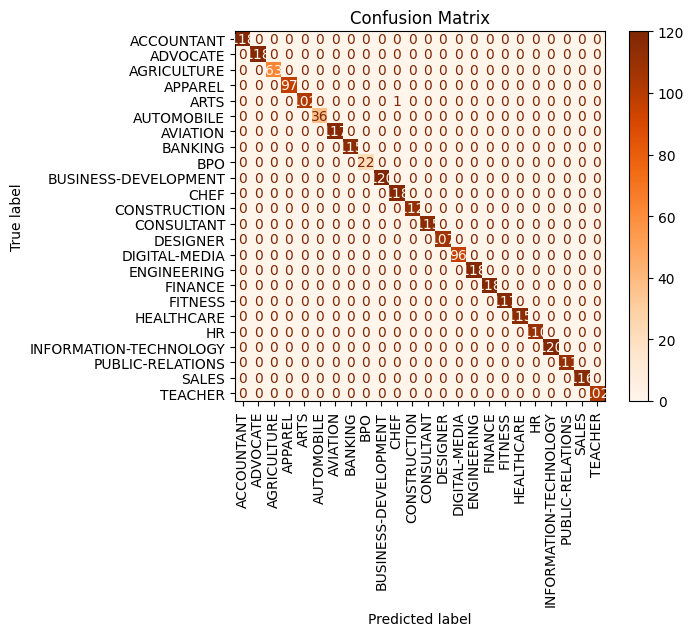

In [18]:
# Confusion Matrix
cm = confusion_matrix(encoded_true_labels, encoded_predicted_labels, labels=np.arange(len(unique_labels)))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=unique_labels)

# Plot confusion matrix
disp.plot(cmap='Oranges', xticks_rotation=90)
plt.title('Confusion Matrix')
plt.show()

## 5. Save and Export the Model

### **Explanation** - After evaluation, the candidate rankings and other necessary data are saved for use in the Flask/FastAPI backend. This ensures that the model can serve predictions without retraining or recomputation.

In [19]:
# Save candidate rankings
with open('candidate_rankings.pkl', 'wb') as f:
    pickle.dump(predictions, f)  # Saving the 'predictions' as rankings

# Save the pretrained BERT model
model_save_path = 'bert_model.pth'
torch.save(model.state_dict(), model_save_path)

# Save the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
tokenizer_save_path = 'bert_tokenizer.pkl'
with open(tokenizer_save_path, 'wb') as f:
    pickle.dump(tokenizer, f)

print("Candidate rankings, model, and tokenizer saved successfully.")

NameError: name 'model' is not defined